# Subthalamic Nucleus neuron
## Validation of the model implementation

### Imports

In [59]:
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
from PySONIC.core import NeuronalBilayerSonophore, PulsedProtocol
from PySONIC.neurons import OtsukaSTN
from PySONIC.utils import logger, si_format, pow10_format, Intensity2Pressure
from PySONIC.plt import CompTimeSeries, GroupedTimeSeries
from PySONIC.constants import *
from PySONIC.postpro import computeFRProfile

logger.setLevel(logging.INFO)

pneuron = OtsukaSTN()
standard_Vm0 = pneuron.Vm0

### Spontaneous spiking activity

The Otsuka paper predicts a spontaneous firing rate around 10 Hz. However, their corresponding figure shows a slightly smaller firing rate, around 6-7 Hz.

<img src="Otsuka/fig1A.png" alt="STN spontaneous firing" style="height: 200px;"/>

 06/12/2019 16:34:02: OtsukaSTN: simulation @ A = 0.00 A/m2, 0.0 s stim, 1.0 s offset


Firing rate: median = 4.82 Hz, last value = 4.86 Hz


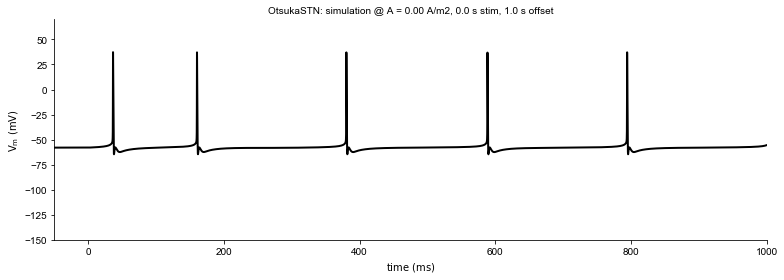

In [60]:
pp = PulsedProtocol(0., 1.)
data, meta = pneuron.simulate(0., pp)
fig = GroupedTimeSeries([(data, meta)], pltscheme={'V_m': ['Vm']}).render()
sr = computeFRProfile(data)
sr = sr[~np.isnan(sr)]
print(f'Firing rate: median = {np.median(sr):.2f} Hz, last value = {sr[-1]:.2f} Hz')

Our simulations show a spontaneous firing stabilizing around 5 Hz. This is within the same order of magnitude as those reported in the Otsuka paper.  

### Response to depolarizing current pulses


The Otsuka paper predicts an increase in the neuron's firing rate from its spontaneous value upon intracellular injection of depolarizing current pulses at 0.5, 2 and 6 uA/cm2:

<img src="Otsuka/fig1D.png" alt="STN depolarizing pulses" style="height: 500px;"/>

 06/12/2019 16:26:10: OtsukaSTN: simulation @ A = 60.00 mA/m2, 1.0 s stim, 0.0 s offset


Firing rate: median = 93.31 Hz, last value = 91.32 Hz


 06/12/2019 16:26:24: OtsukaSTN: simulation @ A = 20.00 mA/m2, 1.0 s stim, 0.0 s offset


Firing rate: median = 50.96 Hz, last value = 50.00 Hz


 06/12/2019 16:26:32: OtsukaSTN: simulation @ A = 5.00 mA/m2, 1.0 s stim, 0.0 s offset


Firing rate: median = 25.21 Hz, last value = 25.16 Hz


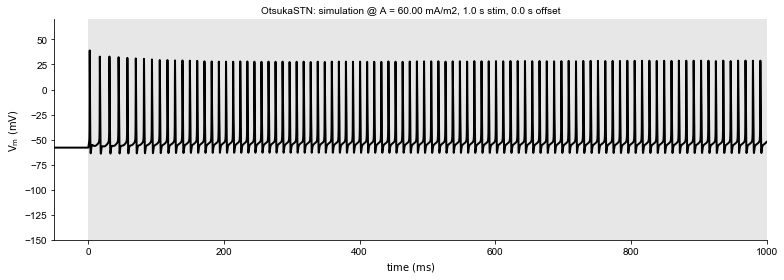

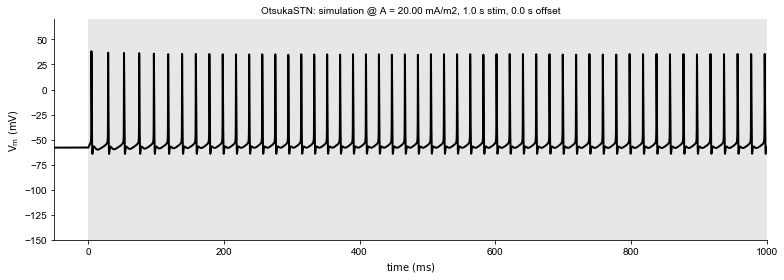

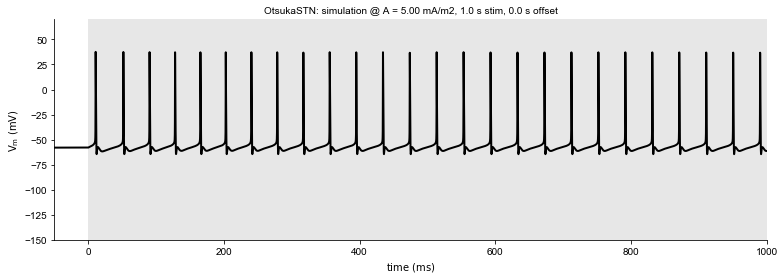

In [52]:
pp = PulsedProtocol(1., 0.)

# Plot Qm profiles for characteristic currents
ref_currents = [60., 20., 5.]
for A in ref_currents:
    data, meta = pneuron.simulate(A, pp)
    fig = GroupedTimeSeries([(data, meta)], pltscheme={'V_m': ['Vm']}).render()    
    sr = computeFRProfile(data)
    sr = sr[~np.isnan(sr)]
    print(f'Firing rate: median = {np.median(sr):.2f} Hz, last value = {sr[-1]:.2f} Hz')

As we can see, the spike rates for the 3 characteristic currents seem accurately reproduced with our implementation.

More globally, the Otsuka paper predicts a quasi-linear increase in the neuron's firing rate with the stimulation amplitude:

<img src="Otsuka/fig1E.png" alt="STN FR vs amplitude" style="height: 200px;"/>

 06/12/2019 14:35:55: OtsukaSTN: simulation @ A = 2.00 mA/m2, 1.0 s stim, 0.0 s offset
 06/12/2019 14:35:58: OtsukaSTN: simulation @ A = 3.01 mA/m2, 1.0 s stim, 0.0 s offset
 06/12/2019 14:36:01: OtsukaSTN: simulation @ A = 4.54 mA/m2, 1.0 s stim, 0.0 s offset
 06/12/2019 14:36:05: OtsukaSTN: simulation @ A = 6.84 mA/m2, 1.0 s stim, 0.0 s offset
 06/12/2019 14:36:10: OtsukaSTN: simulation @ A = 10.31 mA/m2, 1.0 s stim, 0.0 s offset
 06/12/2019 14:36:16: OtsukaSTN: simulation @ A = 15.53 mA/m2, 1.0 s stim, 0.0 s offset
 06/12/2019 14:36:23: OtsukaSTN: simulation @ A = 23.39 mA/m2, 1.0 s stim, 0.0 s offset
 06/12/2019 14:36:32: OtsukaSTN: simulation @ A = 35.24 mA/m2, 1.0 s stim, 0.0 s offset
 06/12/2019 14:36:44: OtsukaSTN: simulation @ A = 53.10 mA/m2, 1.0 s stim, 0.0 s offset
 06/12/2019 14:36:57: OtsukaSTN: simulation @ A = 80.00 mA/m2, 1.0 s stim, 0.0 s offset


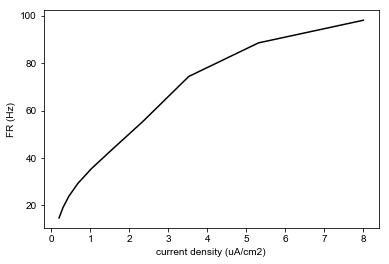

In [44]:
# Plot FR dependency on injected current
currents = np.logspace(np.log10(2), np.log10(80), 10)  # mA/m2
stab_sr = []
for i, A in enumerate(currents):
    data, meta = pneuron.simulate(A, pp)
    sr = computeFRProfile(data)
    stab_sr.append(sr[~np.isnan(sr)][-1])

fig, ax = plt.subplots()
ax.set_xlabel('current density (uA/cm2)')
ax.set_ylabel('FR (Hz)')
ax.plot(currents / 10, stab_sr, c='k', markersize=4)

We obtain a similar dependency profile with our implementation.

### Generation of plateau potentials

The Otsuka paper predicts the induction of long-lasting plateau potentials inducing high-frequency spike bursts in response to small depolarizing pulses preceded by long hyperpolarizing pulses. Moreover, it predicts that the extent of the induced bursts heavily depends on the initial hyperpolarized voltage value:

<img src="Otsuka/fig3B.png" alt="STN plateau potential" style="height: 500px;"/>

Here, we simply re-initialize the STN neuron at a membrane potential lower than its resting potential, in order to mimick the effect of a hyperpolarizing current that would drive the membrane to a hyperpolarized state and hence suppress the neuron's spontaneous activity.

Then, we inject a short depolarizing pulse (50 mA/m2, 50 ms, similarly as in Otsuka 2004), in order to elicit the plateau potential burst of spikes. 

Due to the current implementation, no hyperpolarizing current can be injected after the depolarizing pulse, hence the neuron's spontaneous activity can re-occur after the burst. 

Vm0 = -58.0 mV


 06/12/2019 16:35:48: OtsukaSTN: simulation @ A = 50.00 mA/m2, 50.0 ms stim, 1.5 s offset


Vm0 = -62.0 mV


 06/12/2019 16:35:50: OtsukaSTN: simulation @ A = 50.00 mA/m2, 50.0 ms stim, 1.5 s offset


Vm0 = -66.0 mV


 06/12/2019 16:35:53: OtsukaSTN: simulation @ A = 50.00 mA/m2, 50.0 ms stim, 1.5 s offset


Vm0 = -72.0 mV


 06/12/2019 16:35:58: OtsukaSTN: simulation @ A = 50.00 mA/m2, 50.0 ms stim, 1.5 s offset


Vm0 = -78.0 mV


 06/12/2019 16:36:01: OtsukaSTN: simulation @ A = 50.00 mA/m2, 50.0 ms stim, 1.5 s offset


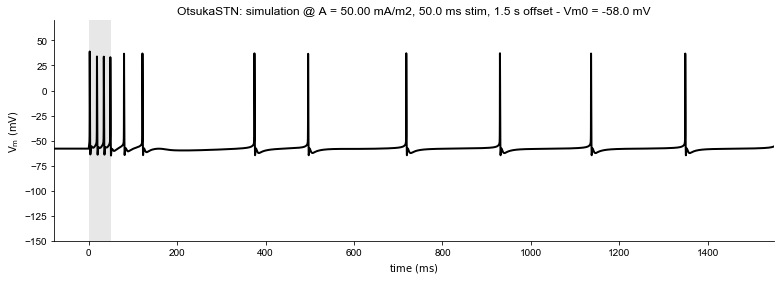

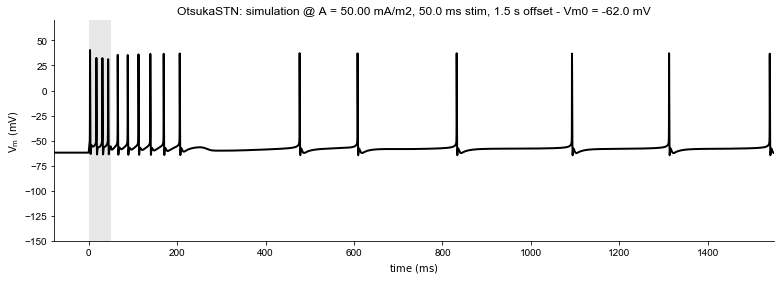

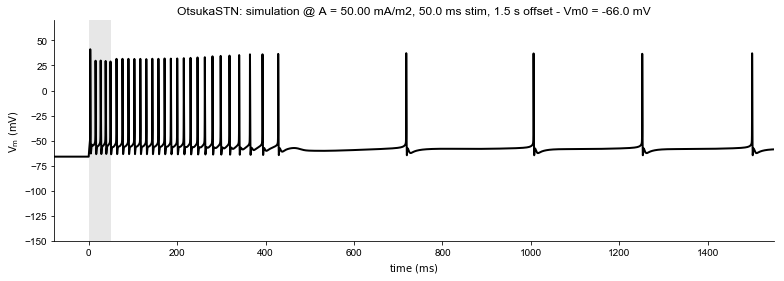

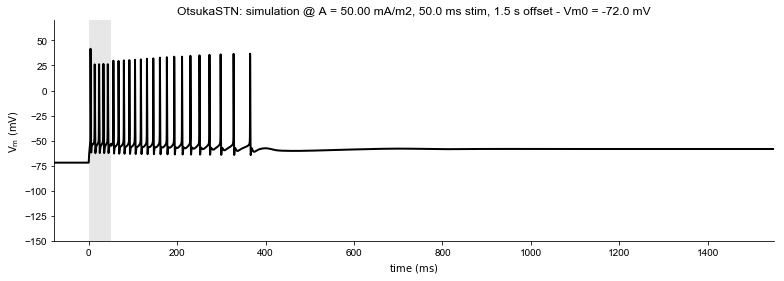

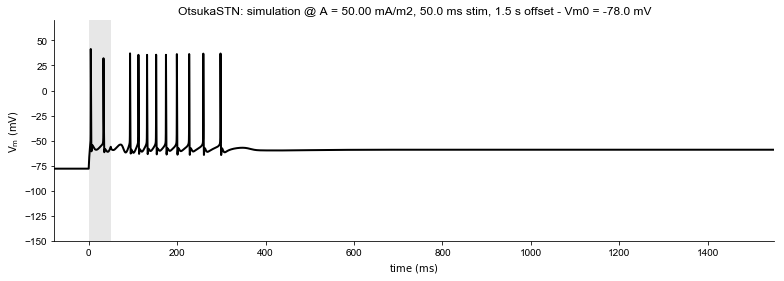

In [64]:
pp = PulsedProtocol(50e-3, 1.5)
for Vm0 in [-58., -62., -66., -72., -78.]:
    OtsukaSTN.Vm0 = Vm0
    pneuron = OtsukaSTN()
    print(f'Vm0 = {pneuron.Vm0} mV')
    data, meta = pneuron.simulate(50., pp)
    fig = GroupedTimeSeries([(data, meta)], pltscheme={'V_m': ['Vm']}).render()[0]
    title = fig.get_axes()[0].get_title()
    fig.get_axes()[0].set_title(f'{title} - Vm0 = {pneuron.Vm0} mV')
OtsukaSTN.Vm0 = standard_Vm0
pneuron = OtsukaSTN()

Despite the slight difference of implementation, we still observe the presence of a burst of spikes that starts at the onset of the depolarizing pulse and then outlasts the stimulus duration.

We also notice that the duration of this burst seems to effectively depend on the initial value of membrane potential, with an optimum of approx. -70 mV at which the burst duration is maximal. This corroborates with the voltage-dependency of plateau potential generation observed in Otsuka 2004.

### Rebound bursting after hyperpolarizing pulses

The Otsuka paper predicts the induction of rebound plateau potentials with high-frequency spike bursts in response to hyperpolarizing pulses.

<img src="Otsuka/fig4D.png" alt="STN rebound potential" style="height:300px;"/>

Vm0 = -58.0 mV


 06/12/2019 17:39:38: OtsukaSTN: simulation @ A = -5.00 mA/m2, 200.0 ms stim, 1.8 s offset
 06/12/2019 17:39:45: OtsukaSTN: simulation @ A = -20.00 mA/m2, 200.0 ms stim, 1.8 s offset
 06/12/2019 17:39:53: OtsukaSTN: simulation @ A = -60.00 mA/m2, 200.0 ms stim, 1.8 s offset


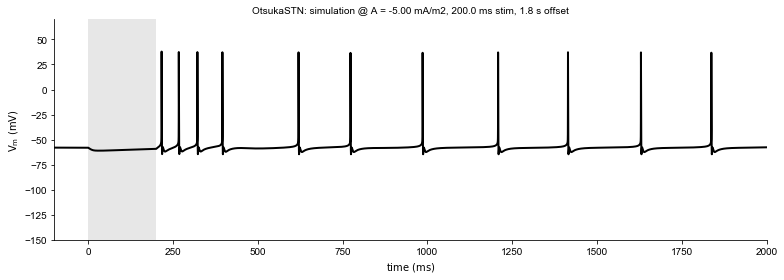

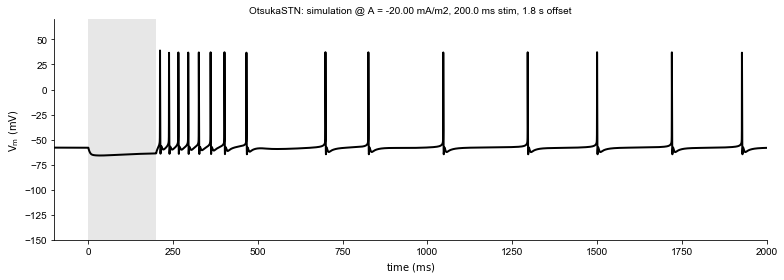

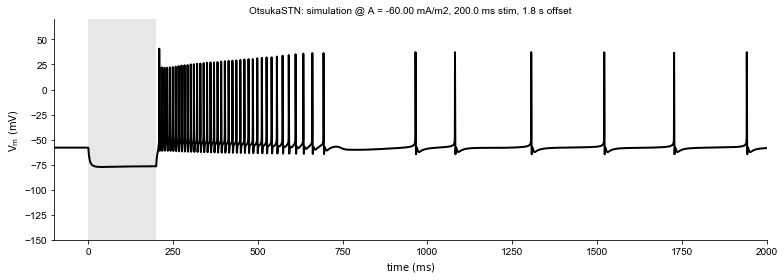

In [69]:
print(f'Vm0 = {pneuron.Vm0} mV')
pp = PulsedProtocol(0.2, 1.8)
for A in [-5., -20., -60.]:
    data, meta = pneuron.simulate(A, pp)
    fig = GroupedTimeSeries([(data, meta)], pltscheme={'V_m': ['Vm']}).render()[0]

We also observe the generation of rebound bursts at the offset of short hyperpolarizing pulses. Again, the burst spike rate and duration is dependent on the intensity of the hyperpolarizing pulse.

### Typical response to US CW stimulation

I = 10 W/m2 (A = 5.58 kPa)


 06/12/2019 17:22:08: NeuronalBilayerSonophore(32.0 nm, OtsukaSTN): sonic simulation @ f = 500.00 kHz, A = 5.58 kPa, 1.0 s stim, 0.0 s offset


I = 110 W/m2 (A = 18.51 kPa)


 06/12/2019 17:23:05: NeuronalBilayerSonophore(32.0 nm, OtsukaSTN): sonic simulation @ f = 500.00 kHz, A = 18.51 kPa, 1.0 s stim, 0.0 s offset


I = 115 W/m2 (A = 18.93 kPa)


 06/12/2019 17:30:12: NeuronalBilayerSonophore(32.0 nm, OtsukaSTN): sonic simulation @ f = 500.00 kHz, A = 18.93 kPa, 1.0 s stim, 0.0 s offset


I = 127 W/m2 (A = 19.89 kPa)


 06/12/2019 17:38:26: NeuronalBilayerSonophore(32.0 nm, OtsukaSTN): sonic simulation @ f = 500.00 kHz, A = 19.89 kPa, 1.0 s stim, 0.0 s offset


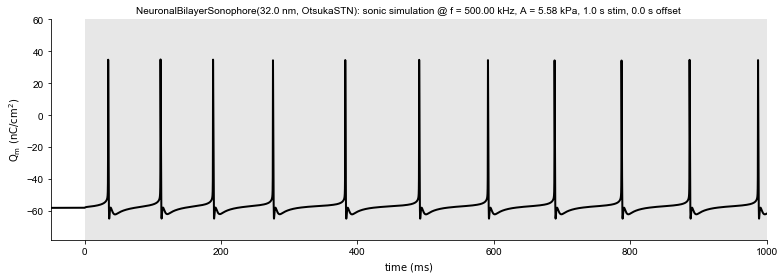

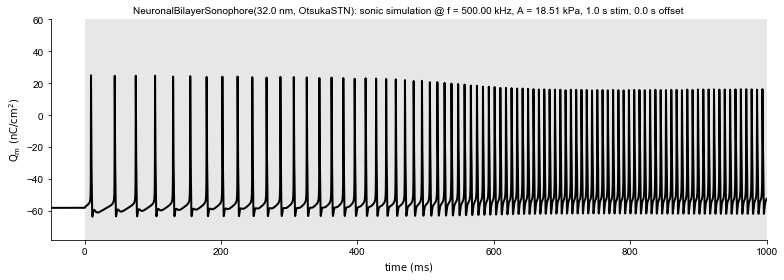

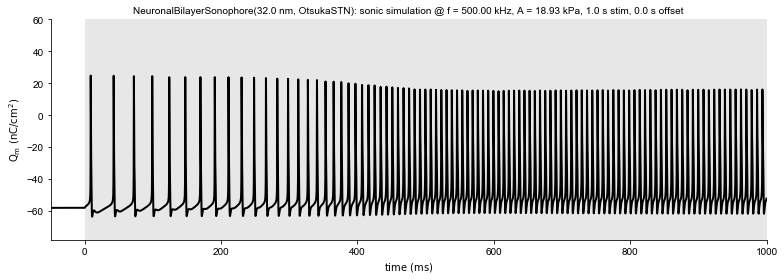

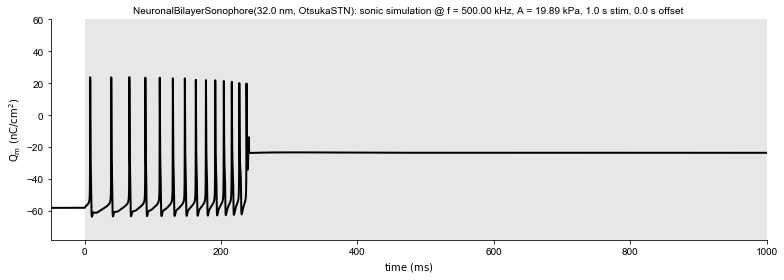

In [68]:
a = 32e-9  # m
Fdrive = 500e3  # Hz
nbls = NeuronalBilayerSonophore(a, pneuron)
pp = PulsedProtocol(1., 0.0)
for I in [10, 110, 115, 127]:
    A = Intensity2Pressure(I, rho=1028.0)
    print(f'I = {I:.0f} W/m2 (A = {(A * 1e-3):.2f} kPa)')
    data, meta = nbls.simulate(Fdrive, A, pp)
    fig = GroupedTimeSeries([(data, meta)], pltscheme={'Q_m': ['Qm']}).render()[0]

We observe a transition between different spiking regimes as a function of acoustic intensity:
- for small intensities (10 to 110 W/m2), the acoustic simulus simply excites the neuron at a constant firing rate, higher than its spontaneous physiological counterpart. Within this regime, increasing acoustic intensity simply raises the obtained firing rate.
- for intermediate intensities (115 W/m2), the acoustic stimulus triggers a neural response in which the firing pattern evolves in time, with spikes increasing in frequency and decrease in amplitude.
- for high intensities (127 W/m2), the acoustic stimulus triggers a few spikes and then a slienced plateau potential.

All those observations are qualitatively similar to those of Tarnaud 2018 for the same intensities (Fig 1).